## Data Annotation for Classification

Training a network for a classification tasks requires per cell annotations that contain the classification label for each cell.
Providing these annotations is often faster than annotations for segmentation, because the annotations are a value per cell (segmented object), rather than a value per pixel (requiring precise painting or interactie segmentation methods as in the `segment_anything` notebook).

Here, we will see how annotations can be generated with napari by creating a small napari plugin to map brushstroke annotations to cell level annotations.

In [ ]:
# General Imports.
import json
import os
import imageio.v3 as imageio

# magicgui is a library to easily extend napari.
# we will use it here to create a button for mapping brushstroke
# annotations to the cell segmentation and saving the annotations.
import magicgui
import napari
import numpy as np

from pathlib import Path
from skimage.measure import regionprops

In [ ]:
# This function will download and unpack the data and do some further data preparation.
# It will only be executed if the data has not been downloaded yet.
data_dir = "../data"
if os.path.exists(data_dir):
    print("The data is downloaded already.")
else:
    utils.prepare_data(data_dir)

In [ ]:
# Load images and segmentation for an example image.

image_id = 0

image_path = os.path.join(data_dir, "train", f"gt_image_00{image_id}", f"gt_image_00{image_id}_serum_image.tif")
serum = imageio.imread(image_path)

image_path = os.path.join(data_dir, "train", f"gt_image_00{image_id}", f"gt_image_00{image_id}_marker_image.tif")
marker = imageio.imread(image_path)

seg_path = os.path.join(data_dir, "train", f"gt_image_00{image_id}", f"gt_image_00{image_id}_cell_labels.tif")
seg = imageio.imread(seg_path)

In [ ]:
# We define a few helper fucntions needed for accumulating and displaying the brushstroke labels.


# Compute the unique (brushstroke) labels for the mask of a segmented cell.
# This will be needed to determine the corrected-per cell label.
def unique_labels(mask, label_data):
    return np.unique(label_data[mask])


# Accumulate the brushstroke labels over the segmentation in order to
# determine the per-cell labels.
def accumulate_labels(segmentation, label_data):
    # 'regionprops' calculates different statistics over a segmentation, for example measures that describe shape and intensity
    # of the objects in the segmentation.
    # We use it here to accumulate the brushstroke labels ('label_data'). In order to compute the label values per
    # cell we pass the 'unique_labels' function as extra measure to compute.
    props = regionprops(segmentation, label_data, extra_properties=[unique_labels])

    # Iterate over the properties and compute the label value for each cell.
    label_list = []
    for prop in props:
        # This returns the unique label values for this cell, i.e. all values in the brushstroke labels
        # that intersect with this cell mask.
        mapped_labels = prop.unique_labels

        # Remove zero from the mapped labels since this is the default value that will always be there.
        mapped_labels = np.setdiff1d(mapped_labels, [0])

        # Assign the cell label:
        if len(mapped_labels) == 0:  # no other value than zero? -> assign label 0 (which means no label)
            this_label = 0
        elif len(mapped_labels) == 1:  # only a single mapped value other than zero? -> assign it as cell label! 
            this_label = mapped_labels[0]
        else:  # multiple mapped label values other than zero? -> we don't know which one to take -> assign unlabeld (0)
            this_label = 0

        # Save the label information, together with the cell id and the bounding box.
        # This is a similar format to the labels that we use in the cell_classification exercise.
        label_list.append({"cell_id": prop.label, "label": int(this_label), "bbox": prop.bbox})
        
    return label_list


# Map the per cell labels back to the segmentation in order to display the result of the label accumulation.
# This way we can check it visually.
def create_labels_for_display(segmentation, label_list):
    label_map = {lab["cell_id"]: lab["label"] for lab in label_list}
    out = np.zeros_like(segmentation)
    for cell_id, label in label_map.items():
        if label == 0:  # don't need to write out zero!
            continue
        out[segmentation == cell_id] = label
    return out

We now want to build a tool where we can paint "brushstrokes" to label cells and then use these annotations to derive per-cell labels. 
Fortunately `napari` provides most of the functionality we need for this already, since it enables painting, can display segmentations etc. But we need to extend it some more to implement the label accumulation. 

Extending `napari` is quite easy thanks to `magicgui`, which enables us to write functions that are turned into small menus and are added to the viewer. You can find more information on magicgui [here]([magicgui](https://napari.org/stable/guides/magicgui.html). Below you find an example how to write a function that adds a new button `Display and export labels` together with a field for specifying a path where the labels are saved as json file.

In [ ]:
viewer = napari.Viewer()
# Add the serum and marker images to the viewer.
viewer.add_image(serum, colormap="green", blending="additive")
viewer.add_image(marker, colormap="red", blending="additive")

# Add the cell segmentation to the viewer and change the display to contours
# so that we can see the image data easily for deciding if cells are infected or not.
seg_layer = viewer.add_labels(seg, name="segmentation")
seg_layer.contour = 2

# We add to empty layers for the class label annotations:
# - 'labels' is the layer we use for providing the brushstroke annotations.
viewer.add_labels(np.zeros_like(seg), name="labels")
# - 'mapped labels (visualization)' is for visualizing the brushstroke labels mapepd to the cells
# (this is only to check that this mapping worked correctly)
viewer.add_labels(np.zeros_like(seg), name="mapped labels (visualization)")


# Create the button for mapping brushstroke labels to the cell segmentation,
# exporting the results to a json file and displaying the result.
# We turn a function into a button by using the '@magicgui.magicgui' decorator.
# The arguments of this function will be turned into additional input fields.
# Here, the 'export_path' is the field for inputting the path for saving the labels.
# Note: magicgui works with type annotations in the function signature, see also
# https://mypy.readthedocs.io/en/stable/cheat_sheet_py3.html
@magicgui.magicgui(call_button="Display and export labels")
def export_labels(viewer: napari.Viewer, export_path: Path):

    layers = viewer.layers
    seg, label_data = layers["segmentation"].data, layers["labels"].data
    label_list = accumulate_labels(seg, label_data)

    for_vis = create_labels_for_display(seg, label_list)
    layers["mapped labels (visualization)"].data = for_vis
    layers["mapped labels (visualization)"].refresh()
    
    with open(export_path, "w") as f:
        json.dump({"cells": label_list}, f)


# Add the button to the viewer.
viewer.window.add_dock_widget(export_labels)

Now use the tool to annotate some cells for infection / non-infection. Check the json file with the annotations afterwards (you can just open it with a text editor).

The animation below shows how the small tool we built is used:

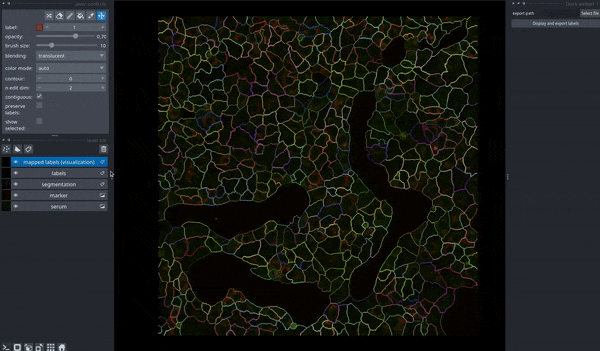